In [1]:
import pandas as pd
from dython.nominal import associations
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['font.size'] = 14 

# 1.0) Datensätze Laden

In [2]:
alt_ges = pd.read_csv('./data/alter_geschlecht.csv', sep=',')
rest = pd.read_csv('./data/rest.csv', sep=';')
interesse = pd.read_csv("./data/interesse.csv", sep=',')

# 2.0) Vorläufige Datenanalyse

In [3]:
print("Alter-Geschlecht:", alt_ges.shape)
print("Rest:", rest.shape)
print("Interesse:", interesse.shape)

Alter-Geschlecht: (508146, 3)
Rest: (508146, 9)
Interesse: (381109, 2)


### 2.1) Duplizierte IDs

In [4]:
print("Alter-Geschlecht:", alt_ges['id'].duplicated().sum())
print("Rest:", rest['id'].duplicated().sum())
print("Interesse:", interesse['id'].duplicated().sum())

Alter-Geschlecht: 0
Rest: 0
Interesse: 0


### 2.2) Fehlwerte

In keinem Datensatz fehlen Werte. Bei fehlenden Werten sollten Imputationsmethoden wie die [multivariate Imputation (z.B. MICE)](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) in Betracht gezogen werden.

In [5]:
print("Alter-Geschlecht:\n", alt_ges.isnull().mean(), "\n\n")
print("Rest:\n", rest.isnull().mean(), '\n\n')
print("Interesse:\n", interesse.isnull().mean())

Alter-Geschlecht:
 id            0.0
Geschlecht    0.0
Alter         0.0
dtype: float64 


Rest:
 Fahrerlaubnis      0.0
Regional_Code      0.0
Vorversicherung    0.0
Alter_Fzg          0.0
Vorschaden         0.0
Jahresbeitrag      0.0
Vertriebskanal     0.0
Kundentreue        0.0
id                 0.0
dtype: float64 


Interesse:
 id           0.0
Interesse    0.0
dtype: float64


# 3.0) Zusammenführung von Datensätzen

Da die Anzahl der eindeutigen IDs in den verschiedenen Datensätzen unterschiedlich ist, wird die Schnittmenge der IDs in den verschiedenen Datensätzen verwendet.

In [6]:
df = pd.merge(interesse, alt_ges, on='id', how='inner').merge(rest, on='id', how='inner').sort_values(by='id').set_index('id')  # id als Index setzen

Der endgültige analytische Datensatz umfasst 381.109 eindeutige IDs.

In [7]:
df.shape

(381109, 11)

### 3.1) Spalten-Datentyp

In [8]:
df.dtypes

Interesse          float64
Geschlecht          object
Alter                int64
Fahrerlaubnis        int64
Regional_Code      float64
Vorversicherung      int64
Alter_Fzg           object
Vorschaden          object
Jahresbeitrag      float64
Vertriebskanal     float64
Kundentreue          int64
dtype: object

In [9]:
# Floats als Integer umwandeln; einige Spalten sind kategorisch und werden im Folgenden als kategorisch umgewandelt
cols = ['Interesse', 'Regional_Code', 'Jahresbeitrag', 'Vertriebskanal']
for col in cols:
    df[col] = df[col].astype('int')

### 3.2) Erste Zeilen des analytischen Datensatzes

In [10]:
df.head()

,Interesse,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue
id,,,,,,,,,,,
1,1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217
2,0,Male,76,1,3,0,1-2 Year,No,33536,26,183
3,1,Male,47,1,28,0,> 2 Years,Yes,38294,26,27
4,0,Male,21,1,11,1,< 1 Year,No,28619,152,203
5,0,Female,29,1,41,1,< 1 Year,No,27496,152,39


# 4.0) Explorative Datenanalyse (EDA)

### 4.1) Assoziationen zwischen (Spalten-)Merkmalen

Die folgende Heatmap zeigt die Beziehung zwischen jedem Merkmal in `df` und allen anderen Merkmalen. Die Messung dieser Beziehung hängt von der Art des Datentyppaares ab:

- Numerisch-Numerisch: [Pearson-Korrelation](https://de.wikipedia.org/wiki/Korrelationskoeffizient_nach_Bravais-Pearson), Wertebereich: -1 bis +1
- Numerisch-Kategorisch: [Correlation Ratio](https://en.wikipedia.org/wiki/Correlation_ratio), Wertebereich: 0 bis +1
- Kategorisch-Kategorisch: [Cramér's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V), Wertebereich: 0 bis +1

Aufgrund der unterschiedlichen Wertebereiche der einzelnen Metriken wird zur besseren Vergleichbarkeit der **absolute Wert** verwendet.

In [11]:
categorical_columns = ['Regional_Code', 'Vertriebskanal']
df_ = df.copy()
for col in categorical_columns:
    df_[col] = df_[col].astype('category')

##### *Anmerkung - Obwohl die Merkmale "Vorschaden", "Fahrerlaubnis", "Vorversicherung" und "Interesse" eigentlich kategorisch sind, da es sich um binäre Variablen handelt, können wir sie für die Modellierung und die statische Auswertung numerisch belassen. Dies vereinfacht das Vorgehen und hat keinen negativen statistischen Einfluss.*

In [12]:
corr = associations(df_, figsize=(15, 15), annot=False, multiprocessing=True, plot=False)

Interpretation: Die folgende Abbildung ist eine Heatmap, die die bivariate Beziehung zwischen den verschiedenen Spaltenkombinationen zeigt. Diese Beziehung wird als absoluter Wert dargestellt, so dass jeder Wert zwischen 0 und 1 liegt, wobei höhere Werte (dunklere Quadrate) eine stärkere bivariate Beziehung anzeigen.

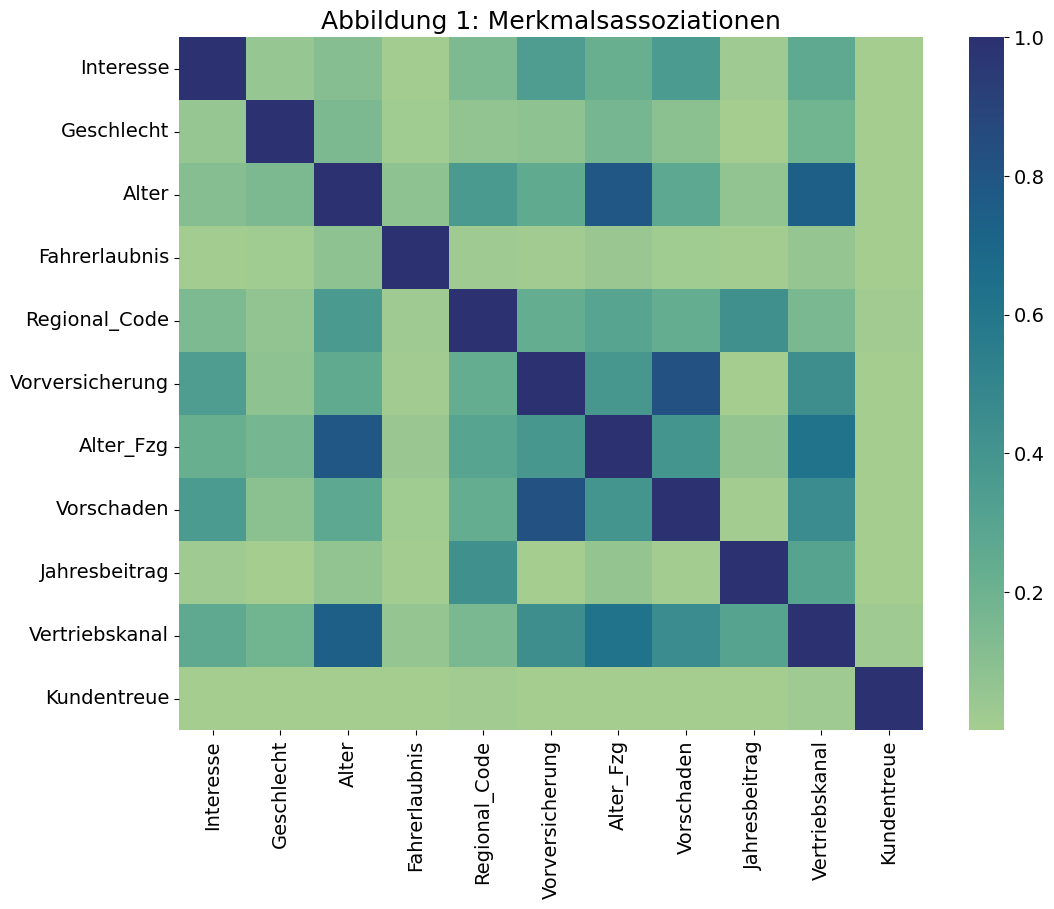

In [13]:
plt.figure(figsize=(12,9))
sns.heatmap(abs(corr['corr']), cmap='crest')
plt.title('Abbildung 1: Merkmalsassoziationen', fontsize=18)
plt.show()

### 4.2) Bivariate Merkmalsassoziationen mit der Zielvariable

Die folgende Abbildung 2 zeigt den bivariaten Zusammenhang zwischen den einzelnen Merkmalen und der Ergebnisvariablen „Interesse“ unter Verwendung der oben beschriebenen Maße.

Interpretation: Es zeigt sich, dass die Merkmale "Vorschaden", "Vorversicherung" und "Vertriebsweg" am stärksten mit der Zielgröße korrelieren.

In [14]:
corr_outcome = abs(corr['corr'].iloc[0, 1:]).sort_values(ascending=False)

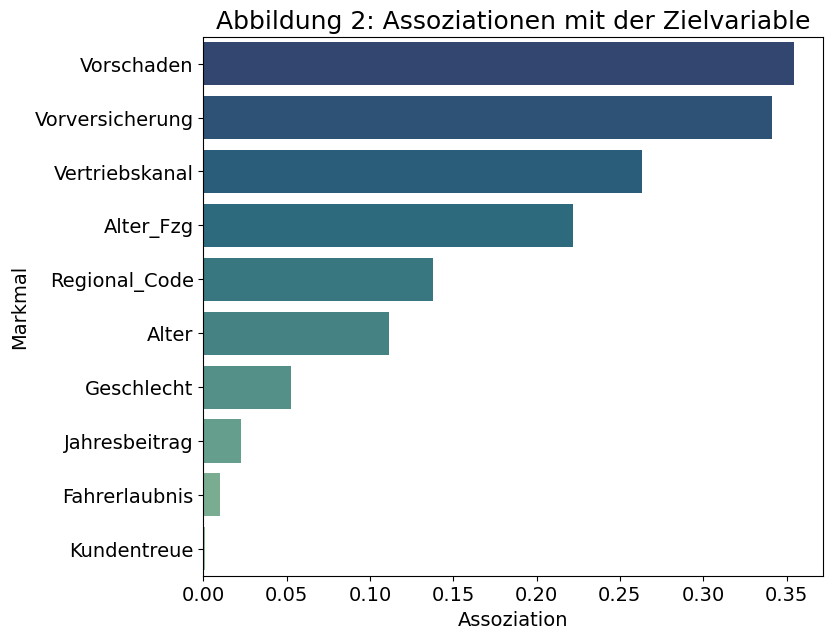

In [15]:
plt.figure(figsize=(8, 7))

num_categories = len(corr_outcome.index)  # Number of unique y-values
palette = sns.color_palette("crest", num_categories)[::-1]  # Reverse the color list

sns.barplot(
    x=corr_outcome.values, 
    y=corr_outcome.index, 
    hue=corr_outcome.index,
    palette=palette, 
    legend=False
)
plt.xlabel("Assoziation")
plt.ylabel("Markmal")
plt.title('Abbildung 2: Assoziationen mit der Zielvariable', fontsize=18)
plt.show()